In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch_geometric.nn as pyg_nn
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from itertools import cycle

In [2]:
# 1.加载Cora数据集
dataset = Planetoid(root='./data/Cora', name='Cora')

In [3]:
# 2.定义GCNConv网络
class GCN(nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = pyg_nn.GCNConv(num_node_features, 252)
        self.conv2 = pyg_nn.GCNConv(252, 42)
        self.conv3 = pyg_nn.GCNConv(42, num_classes)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index)
        x = F.leaky_relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.leaky_relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv3(x, edge_index)
        
        return F.softmax(x, dim=1)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 设备
epochs = 50 # 学习轮数
lr = 0.001 # 学习率
num_node_features = dataset.num_node_features # 每个节点的特征数
num_classes = dataset.num_classes # 每个节点的类别数
data = dataset[0].to(device) # 将Cora图加载至计算设备中

In [5]:
# 3.定义模型
model = GCN(num_node_features, num_classes).to(device) #实例化模型
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # 优化器
loss_function = nn.CrossEntropyLoss() # 损失函数

In [6]:
# 训练模式
model.train()

for epoch in range(epochs):
    optimizer.zero_grad()
    pred = model(data)
    
    loss = loss_function(pred[data.train_mask], data.y[data.train_mask]) # 损失
    correct_count_train = pred.argmax(axis=1)[data.train_mask].eq(data.y[data.train_mask]).sum().item() # epoch正确分类数目
    acc_train = correct_count_train / data.train_mask.sum().item() # epoch训练精度
    
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print("【EPOCH: 】%s" % str(epoch + 1))
        print('训练损失为：{:.4f}'.format(loss.item()), '训练精度为：{:.4f}'.format(acc_train))

print('【Finished Training！】')

【EPOCH: 】10
训练损失为：1.8654 训练精度为：0.8071
【EPOCH: 】20
训练损失为：1.6273 训练精度为：0.8857
【EPOCH: 】30
训练损失为：1.3942 训练精度为：0.9214
【EPOCH: 】40
训练损失为：1.2685 训练精度为：0.9500
【EPOCH: 】50
训练损失为：1.2258 训练精度为：0.9714
【Finished Training！】


In [7]:
# 模型验证
model.eval()
pred = model(data)

In [8]:
# 训练集 (利用掩码来实现数据筛选)
correct_count_train = pred.argmax(axis=1)[data.train_mask].eq(data.y[data.train_mask]).sum().item()
acc_train = correct_count_train / data.train_mask.sum().item()
loss_train = loss_function(pred[data.train_mask], data.y[data.train_mask]).item()

In [9]:
#验证集
correct_count_val = pred.argmax(axis=1)[data.val_mask].eq(data.y[data.val_mask]).sum().item()
acc_val = correct_count_val / data.val_mask.sum().item()
loss_val = loss_function(pred[data.val_mask], data.y[data.val_mask]).item()

In [10]:
# 测试集
correct_count_test = pred.argmax(axis=1)[data.test_mask].eq(data.y[data.test_mask]).sum().item()
acc_test = correct_count_test / data.test_mask.sum().item()
loss_test = loss_function(pred[data.test_mask], data.y[data.test_mask]).item()

In [17]:
#F1
with torch.no_grad():
    F1=metrics.f1_score(pred.argmax(axis=1)[data.test_mask],data.y[data.test_mask],average='weighted')

In [18]:
print('Train Accuracy: {:.4f}'.format(acc_train), 'Train Loss: {:.4f}'.format(loss_train))
print('Val   Accuracy: {:.4f}'.format(acc_val), 'Val   Loss: {:.4f}'.format(loss_val))
print('Test  Accuracy: {:.4f}'.format(acc_test), 'Test  Loss: {:.4f}'.format(loss_test))
print('F1            : {:.4f}'.format(F1))

Train Accuracy: 0.9929 Train Loss: 1.1984
Val   Accuracy: 0.7840 Val   Loss: 1.4254
Test  Accuracy: 0.8000 Test  Loss: 1.4095
F1            : 0.7986


In [13]:
y_pred=pred[data.test_mask] #在测试集上的预测值
y_label=torch.zeros(y_pred.size()) #用于生成真实的标签（以one-hot形式）
for i in range(num_classes):
    y_label[:,i]=data.y[data.test_mask].eq(i)  #第i类真实标签

In [14]:
with torch.no_grad():
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_label[:, i], y_pred[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

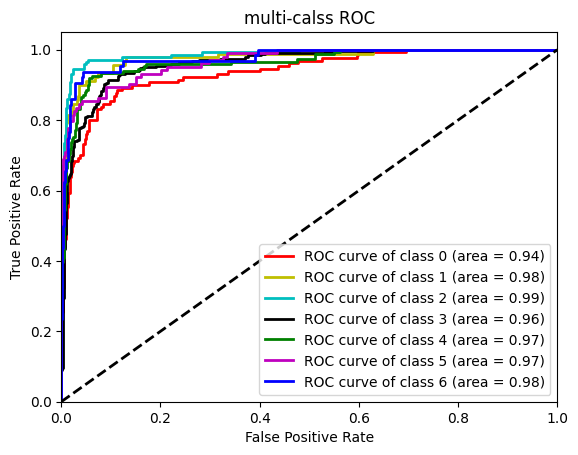

In [15]:
lw=2
colors = cycle(['r', 'y', 'c','k','g','m','b','pink','olive'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
 
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('multi-calss ROC')
plt.legend(loc="lower right")
plt.show()
